<h1>Read beta value CSV file and spit  in to training and validation and test sets<h1/>
    use hyperimpute to imute tht diffrent splits seperatly

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from hyperimpute.plugins.imputers import Imputers

# Load the data
df = pd.read_csv('filter_betas.csv', sep=',', index_col=0) # for classification problem

# Separate the feature data (X) and binary group labels (y)
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Last column (binary group labels)

# Set seed
np.random.seed(42)

# Split the data into training, testing, and validation sets using a 70/20/10 split
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test_temp, y_test_temp, test_size=0.5, random_state=42, stratify=y_test_temp)

# Step 1: Separate cases and control data for training set
cases_X_train = X_train[y_train == 1]
control_X_train = X_train[y_train == 0]

# Step 2: Impute the missing values separately for cases and control data in the training set
imputers = Imputers()
method = "hyperimpute"
plugin = imputers.get(method)

imputed_cases_X_train = plugin.fit_transform(cases_X_train.copy())
imputed_control_X_train = plugin.fit_transform(control_X_train.copy())

# Concatenate the imputed cases and control data back together in the training set
imputed_X_train = pd.concat([pd.DataFrame(imputed_cases_X_train, columns=cases_X_train.columns),
                            pd.DataFrame(imputed_control_X_train, columns=control_X_train.columns)])
y_train_imputed = np.concatenate((np.ones(imputed_cases_X_train.shape[0]), np.zeros(imputed_control_X_train.shape[0])))

# Convert back to DataFrame (optional, if needed) in the training set
imputed_X_train = pd.DataFrame(imputed_X_train, columns=X_train.columns)

# Step 3: Impute the test and validation data separately
imputed_X_test = plugin.fit_transform(X_test.copy())
imputed_X_val = plugin.fit_transform(X_val.copy())

# Convert back to DataFrame (optional, if needed) in the test and validation sets
imputed_X_test = pd.DataFrame(imputed_X_test, columns=X_test.columns)
imputed_X_val = pd.DataFrame(imputed_X_val, columns=X_val.columns)

# Now imputed_X_train contains the imputed X_train data with the original layout, including feature names and sample IDs
# You can use this DataFrame for further analysis or modeling tasks
print(imputed_X_train.head())
print(imputed_X_test.head())
print(imputed_X_val.head())


/data/home/bt22880/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:126: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: User

   chr1_116052050_116052052  chr1_116052074_116052076  \
0                  0.763684                  0.809079   
1                  1.000000                  0.808890   
2                  0.751526                  0.909091   
3                  0.700000                  0.666667   
4                  1.000000                  1.000000   

   chr1_116052078_116052080  chr1_116052080_116052082  \
0                  0.835833                  0.807595   
1                  0.923077                  1.000000   
2                  1.000000                  0.909091   
3                  0.909091                  0.909091   
4                  1.000000                  1.000000   

   chr1_116052085_116052087  chr1_116052112_116052114  \
0                  0.750000                  0.583333   
1                  0.933333                  0.785714   
2                  0.818182                  0.727273   
3                  0.909091                  0.800000   
4                  0.846154  

/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 800x600 with 0 Axes>

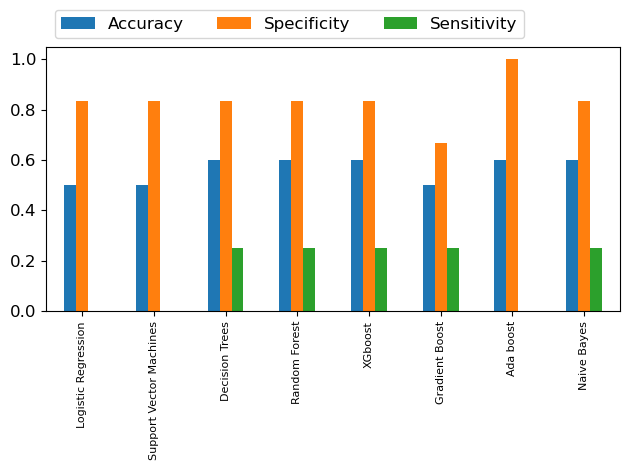

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(random_state=42)

# Support Vector Machines
from sklearn.svm import SVC 
models['Support Vector Machines'] = SVC(random_state=42,)

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier(random_state=42)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(random_state=42,)

# XGboost
import xgboost as xgb
models['XGboost'] = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
models['Gradient Boost'] = GradientBoostingClassifier(random_state=42)

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
models['Ada boost'] = AdaBoostClassifier(random_state=42)

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

accuracy, precision, recall, specificity, sensitivity = {}, {}, {}, {}, {}

for key in models.keys():
    # Fit the classifier model
    models[key].fit(imputed_X_train, y_train_imputed)

    # Prediction
    predictions = models[key].predict(imputed_X_test)

    # Calculate Accuracy, Precision, Recall, Specificity, and Sensitivity Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, predictions)

    # Calculate Specificity and Sensitivity
    tn, fp, fn, tp = cm.ravel()
    specificity[key] = tn / (tn + fp)
    sensitivity[key] = tp / (tp + fn)

# Create a DataFrame with the metrics
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Specificity', 'Sensitivity'])
df_model['Accuracy'] = accuracy.values()
df_model['Specificity'] = specificity.values()
df_model['Sensitivity'] = sensitivity.values()

#print(df_model)

# Plot the bar chart
plt.figure(figsize=(8, 6))  # Set the figure size before creating the plot
ax = df_model.plot.bar(rot=90)

# Increase the font size of the legend
legend_font_size = 12  # Set your desired font size here
ax.legend(ncol=len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': legend_font_size})
plt.xticks(fontsize=8)  # Set the font size of the x-axis tick labels
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12) 
plt.tight_layout()
plt.show()


<h1>Hyperparameter tuning using GridSearchCV <h1/>

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000),
    'Support Vector Machines': SVC(random_state=42,),
    'Decision Trees': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGboost': xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_jobs=-1),
    'Gradient Boost': GradientBoostingClassifier(random_state=42),
    'Ada boost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
    #add NN
}
   

# Dictionary of the hyperparameter grids for each model
# Define a dictionary to store the hyperparameter grids for each model

param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [50, 100, 200, 500]
    },
    'Support Vector Machines': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'degree': [2, 3, 4],
    },
    'Decision Trees': {
        'max_depth': [None, 10, 20, 50],
        'min_samples_split': [2, 5, 10],
        'criterion': ['entropy'],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt'],
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 25, 50, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False],
    },
    'XGboost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.5, 1],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'n_estimators': [50, 100, 200, 500],
    },
    'Gradient Boost': {
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200, 500],
        'subsample': [0.7, 0.8],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'Ada boost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.5],
    }
}

# Define a dictionary to store the best models and their corresponding hyperparameters
best_models = {}

# Perform GridSearchCV for each model
for key in models.keys():
    # Define the GridSearchCV with the appropriate model and hyperparameter grid
    if key in param_grids:
        grid_search = GridSearchCV(models[key], param_grids[key], cv=5, scoring='recall', n_jobs=-1, verbose=1)
        # Fit the GridSearchCV to the data
        grid_search.fit(imputed_X_train.values, y_train)


        # Store the best model and its hyperparameters in the best_models dictionary
        best_models[key] = {
            'best_model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
    else:
        # If the model does not require hyperparameter tuning, add it directly to best_models
        best_models[key] = {'best_model': models[key], 'best_params': None, 'best_score': None}


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does no

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
334 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2442 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraint

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [64]:
for model_name, model_info in best_models.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {model_info['best_params']}")
    print(f"Best Score: {model_info['best_score']}")
    print("\n")

Model: Logistic Regression
Best Parameters: {'C': 100.0, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.38


Model: Support Vector Machines
Best Parameters: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.39


Model: Decision Trees
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score: 0.42000000000000004


Model: Random Forest
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.3


Model: XGboost
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best Score: 0.38


Model: Gradient Boost
Best Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.7}
Best Score:

                        Accuracy Specificity Sensitivity
Logistic Regression          0.5         0.4         0.6
Support Vector Machines      0.6         0.6         0.6
Decision Trees               0.7         0.6         0.8
Random Forest                0.7         1.0         0.4
XGboost                      0.6         0.6         0.6
Gradient Boost               0.6         0.6         0.6
Ada boost                    0.6         0.4         0.8
Naive Bayes                  0.4         0.6         0.2


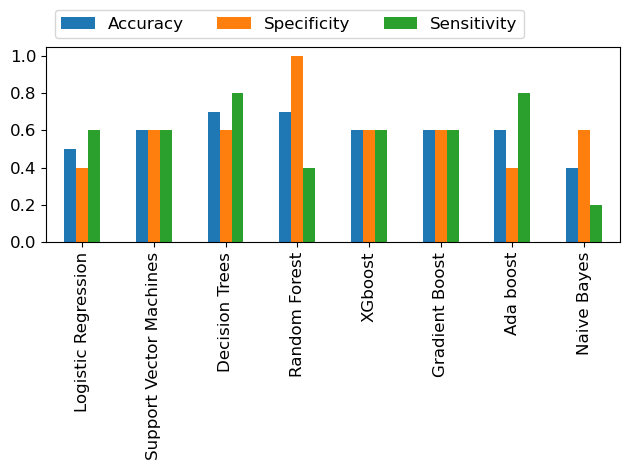

<Figure size 800x600 with 0 Axes>

In [166]:
# Initialize an empty DataFrame to store the evaluation metrics
df_best_models = pd.DataFrame(index=best_models.keys(), columns=['Accuracy', 'Specificity', 'Sensitivity'])

for key in best_models.keys():
    # Get the best model from the best_models dictionary
    best_model = best_models[key]['best_model']
    
    if key == 'Naive Bayes':
        # Fit the Naive Bayes model directly to the training data
        best_model.fit(imputed_X_train.values, y_train)
    
    # Prediction
    predictions = best_model.predict(imputed_X_val.values)  # Convert to NumPy array

    # Calculate Accuracy, Precision, Recall, Specificity, and Sensitivity Metrics
    df_best_models.at[key, 'Accuracy'] = accuracy_score(predictions, y_val)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_val, predictions)

    # Calculate Specificity and Sensitivity
    tn, fp, fn, tp = cm.ravel()
    df_best_models.at[key, 'Specificity'] = tn / (tn + fp)
    df_best_models.at[key, 'Sensitivity'] = tp / (tp + fn)

# Plot the bar chart
ax = df_best_models.plot.bar(rot=90)

print(df_best_models)

# Increase the font size of the legend and labels
legend_font_size = 12  # Set your desired font size here
ax.legend(ncol=len(df_best_models.columns), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': legend_font_size})
plt.xticks(fontsize=12)  # Set the font size of the x-axis tick labels
plt.yticks(fontsize=12)  # Set the font size of the y-axis tick labels
plt.tight_layout()
plt.figure(figsize=(8, 6))
plt.show()

                        Accuracy Specificity Sensitivity
Logistic Regression          0.5    0.333333        0.75
Support Vector Machines      0.5    0.666667        0.25
Decision Trees               0.7    0.666667        0.75
Random Forest                0.5         0.5         0.5
XGboost                      0.4         0.5        0.25
Gradient Boost               0.4    0.333333         0.5
Ada boost                    0.5    0.333333        0.75
Naive Bayes                  0.5    0.666667        0.25


<Figure size 800x600 with 0 Axes>

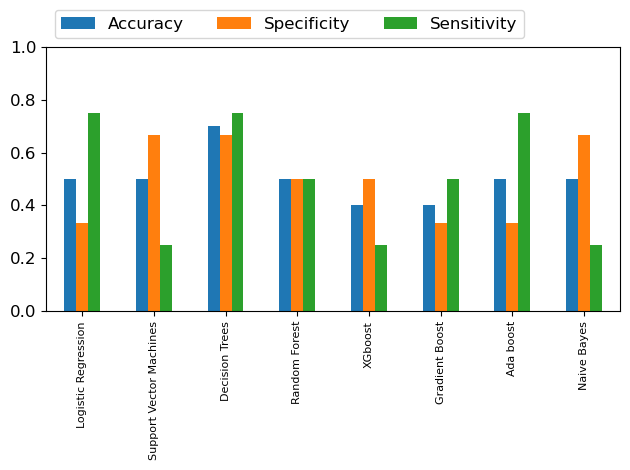

In [197]:
# Initialize an empty DataFrame to store the evaluation metrics
df_best_models = pd.DataFrame(index=best_models.keys(), columns=['Accuracy', 'Specificity', 'Sensitivity'])

for key in best_models.keys():
    # Get the best model from the best_models dictionary
    best_model = best_models[key]['best_model']
    
    if key == 'Naive Bayes':
        # Fit the Naive Bayes model directly to the training data
        best_model.fit(imputed_X_train.values, y_train)
    
    # Prediction
    predictions = best_model.predict(imputed_X_test.values)  # Convert to NumPy array

    # Calculate Accuracy, Precision, Recall, Specificity, and Sensitivity Metrics
    df_best_models.at[key, 'Accuracy'] = accuracy_score(predictions, y_test)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, predictions)

    # Calculate Specificity and Sensitivity
    tn, fp, fn, tp = cm.ravel()
    df_best_models.at[key, 'Specificity'] = tn / (tn + fp)
    df_best_models.at[key, 'Sensitivity'] = tp / (tp + fn)

    
print(df_best_models)
# Set the figure size before creating the plot
plt.figure(figsize=(8, 6))

# Plot the bar chart
ax = df_best_models.plot.bar(rot=90)

# Increase the font size of the legend and labels
legend_font_size = 12  # Set your desired font size here
ax.legend(ncol=len(df_best_models.columns), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': legend_font_size})
plt.xticks(fontsize=8)  # Set the font size of the x-axis tick labels
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)  # Set the font size of the y-axis tick labels
plt.tight_layout()
plt.show()


<h1>Chosen models for hand tuning <h1/>

                     Accuracy  Specificity  Sensitivity
Logistic Regression       0.6     0.500000         0.75
Decision Trees            0.7     0.666667         0.75
Ada boost                 0.7     0.666667         0.75


<Figure size 800x600 with 0 Axes>

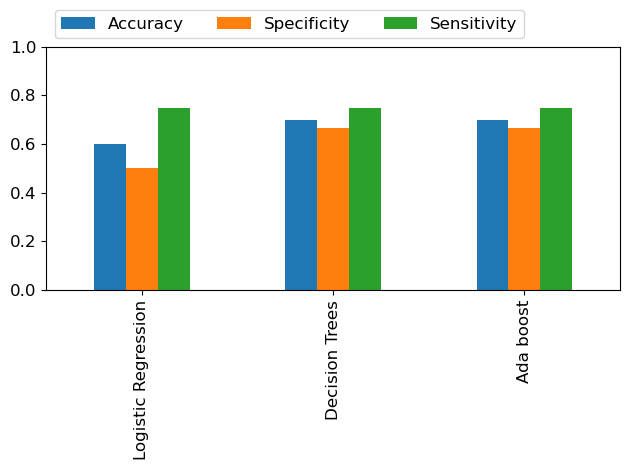

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(C=7, penalty='l1', solver='liblinear', max_iter=120)


# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] =  DecisionTreeClassifier(random_state=42, criterion ='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')


# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
models['Ada boost'] = AdaBoostClassifier(n_estimators=160, random_state=42, learning_rate=0.5,)


accuracy, precision, recall, specificity, sensitivity = {}, {}, {}, {}, {}

for key in models.keys():
    # Fit the classifier model
    models[key].fit(imputed_X_train, y_train)

    # Prediction
    predictions = models[key].predict(imputed_X_test)

    # Calculate Accuracy, Precision, Recall, Specificity, and Sensitivity Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, predictions)

    # Calculate Specificity and Sensitivity
    tn, fp, fn, tp = cm.ravel()
    specificity[key] = tn / (tn + fp)
    sensitivity[key] = tp / (tp + fn)

# Create a DataFrame with the metrics
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Specificity', 'Sensitivity'])
df_model['Accuracy'] = accuracy.values()
df_model['Specificity'] = specificity.values()
df_model['Sensitivity'] = sensitivity.values()

print(df_model)

# Plot the bar chart
ax = df_model.plot.bar(rot=90)
plt.figure(figsize=(8, 6))
# Increase the font size of the legend
legend_font_size = 12  # Set your desired font size here
ax.legend(ncol=len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': legend_font_size})
plt.xticks(fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.tight_layout()
plt.show()

/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Model Metrics at Chosen Threshold:
Threshold: 0.6651
Accuracy: 0.600
Sensitivity: 0.500
Specificity: 0.667


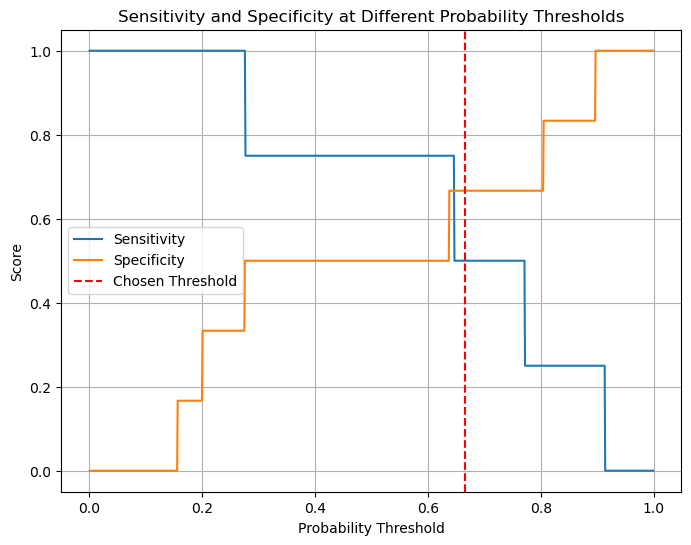

In [224]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Create a Logistic Regression model with specific hyperparameters
LR = LogisticRegression(C=7, penalty='l1', solver='liblinear', max_iter=120)

# Fit the Logistic Regression model to the training data
LR.fit(imputed_X_train, y_train)

# Make predictions on the validation data
y_prob = LR.predict_proba(imputed_X_test.values)[:, 1]

# Choose a specific threshold for classification
chosen_threshold = 0.6651

# Make binary predictions based on the chosen threshold
y_pred_binary = (y_prob >= chosen_threshold).astype(int)

# Calculate accuracy using the accuracy_score function from scikit-learn
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate the confusion matrix using the confusion_matrix function from scikit-learn
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Calculate sensitivity and specificity from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print the model metrics at the chosen threshold
print("Model Metrics at Chosen Threshold:")
print(f"Threshold: {chosen_threshold}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# Plot sensitivity and specificity at different probability thresholds
thresholds = np.arange(0.001, 1.0, 0.001)
sensitivity_values = []
specificity_values = []

for threshold in thresholds:
    y_pred_binary = (y_prob >= threshold).astype(int)
    TP = np.sum((y_test == 1) & (y_pred_binary == 1))
    FP = np.sum((y_test == 0) & (y_pred_binary == 1))
    TN = np.sum((y_test == 0) & (y_pred_binary == 0))
    FN = np.sum((y_test == 1) & (y_pred_binary == 0))
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    sensitivity_values.append(sensitivity)
    specificity_values.append(specificity)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity_values, label='Sensitivity')
plt.plot(thresholds, specificity_values, label='Specificity')
plt.axvline(x=chosen_threshold, color='red', linestyle='--', label='Chosen Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity at Different Probability Thresholds')
plt.legend()
plt.grid(True)
plt.show()


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Model Metrics at Chosen Threshold:
Threshold: 0.6648
Accuracy: 0.700
Sensitivity: 0.800
Specificity: 0.600


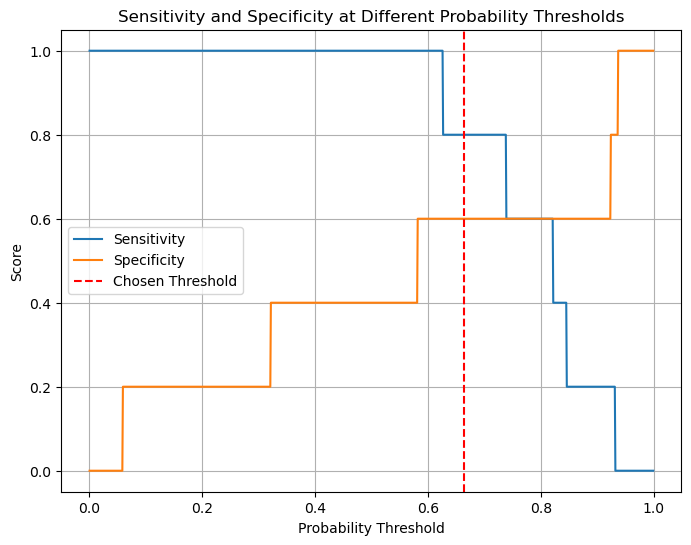

In [225]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Create a Logistic Regression model with specific hyperparameters
LR = LogisticRegression(C=7, penalty='l1', solver='liblinear', max_iter=120)

# Fit the Logistic Regression model to the training data
LR.fit(imputed_X_train, y_train)

# Make predictions on the validation data
y_prob = LR.predict_proba(imputed_X_val.values)[:, 1]

# Choose a specific threshold for classification
chosen_threshold = 0.6648


# Make binary predictions based on the chosen threshold
y_pred_binary = (y_prob >= chosen_threshold).astype(int)

# Calculate accuracy using the accuracy_score function from scikit-learn
accuracy = accuracy_score(y_val, y_pred_binary)

# Calculate the confusion matrix using the confusion_matrix function from scikit-learn
conf_matrix = confusion_matrix(y_val, y_pred_binary)

# Calculate sensitivity and specificity from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print the model metrics at the chosen threshold
print("Model Metrics at Chosen Threshold:")
print(f"Threshold: {chosen_threshold}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# Plot sensitivity and specificity at different probability thresholds
thresholds = np.arange(0.001, 1.0, 0.001)
sensitivity_values = []
specificity_values = []

for threshold in thresholds:
    y_pred_binary = (y_prob >= threshold).astype(int)
    TP = np.sum((y_val == 1) & (y_pred_binary == 1))
    FP = np.sum((y_val == 0) & (y_pred_binary == 1))
    TN = np.sum((y_val == 0) & (y_pred_binary == 0))
    FN = np.sum((y_val == 1) & (y_pred_binary == 0))
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    sensitivity_values.append(sensitivity)
    specificity_values.append(specificity)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity_values, label='Sensitivity')
plt.plot(thresholds, specificity_values, label='Specificity')
plt.axvline(x=chosen_threshold, color='red', linestyle='--', label='Chosen Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity at Different Probability Thresholds')
plt.legend()
plt.grid(True)
plt.show()

/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Model Metrics at Chosen Threshold (Training Data):
Threshold: 0.6645
Training Accuracy: 0.956
Training Sensitivity: 0.905
Training Specificity: 1.000

Model Metrics at Chosen Threshold (Testing Data):
Threshold: 0.6645
Testing Accuracy: 0.700
Testing Sensitivity: 0.750
Testing Specificity: 0.667


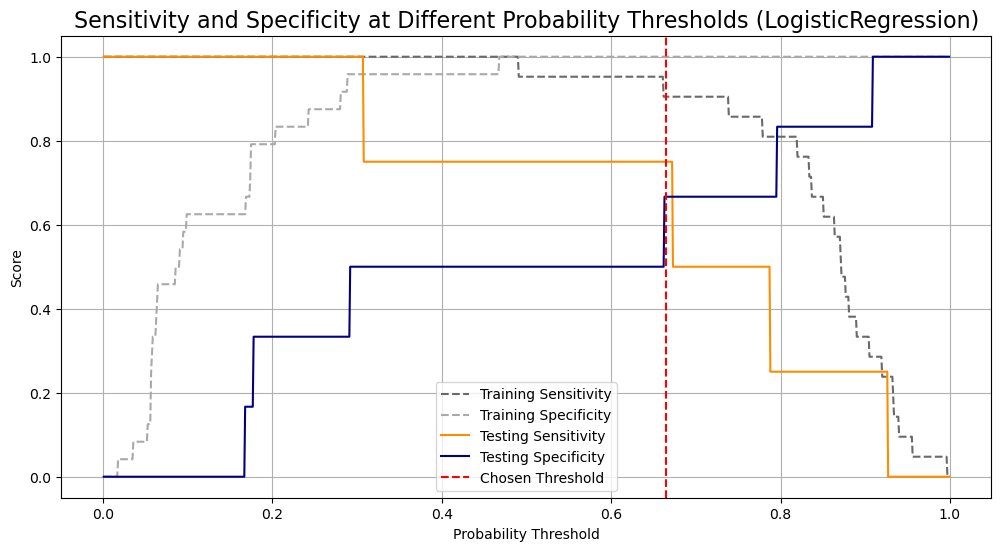

In [235]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Create a Logistic Regression model with specific hyperparameters
LR = LogisticRegression(C=7, penalty='l1', solver='liblinear', max_iter=120)

# Fit the Logistic Regression model to the training data
LR.fit(imputed_X_train, y_train)

# Make predictions on the validation data
y_prob_val = LR.predict_proba(imputed_X_val.values)[:, 1]
y_prob_train = LR.predict_proba(imputed_X_train.values)[:, 1]
y_prob_test = LR.predict_proba(imputed_X_test.values)[:, 1]

# Choose a specific threshold for classification
chosen_threshold = 0.6645
# Make binary predictions based on the chosen threshold for validation data
y_pred_binary_val = (y_prob_val >= chosen_threshold).astype(int)

# Make binary predictions based on the chosen threshold for training data
y_pred_binary_train = (y_prob_train >= chosen_threshold).astype(int)

# Make binary predictions based on the chosen threshold for testing data
y_pred_binary_test = (y_prob_test >= chosen_threshold).astype(int)

# Calculate accuracy for validation, training, and testing data
accuracy_val = accuracy_score(y_val, y_pred_binary_val)
accuracy_train = accuracy_score(y_train, y_pred_binary_train)
accuracy_test = accuracy_score(y_test, y_pred_binary_test)

# Calculate the confusion matrix for validation, training, and testing data
conf_matrix_val = confusion_matrix(y_val, y_pred_binary_val)
conf_matrix_train = confusion_matrix(y_train, y_pred_binary_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_binary_test)

# Calculate sensitivity and specificity from the confusion matrix for validation, training, and testing data
TN_val, FP_val, FN_val, TP_val = conf_matrix_val.ravel()
sensitivity_val = TP_val / (TP_val + FN_val)
specificity_val = TN_val / (TN_val + FP_val)

TN_train, FP_train, FN_train, TP_train = conf_matrix_train.ravel()
sensitivity_train = TP_train / (TP_train + FN_train)
specificity_train = TN_train / (TN_train + FP_train)

TN_test, FP_test, FN_test, TP_test = conf_matrix_test.ravel()
sensitivity_test = TP_test / (TP_test + FN_test)
specificity_test = TN_test / (TN_test + FP_test)


print("\nModel Metrics at Chosen Threshold (Training Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Training Accuracy: {accuracy_train:.3f}")
print(f"Training Sensitivity: {sensitivity_train:.3f}")
print(f"Training Specificity: {specificity_train:.3f}")

print("\nModel Metrics at Chosen Threshold (Testing Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Testing Accuracy: {accuracy_test:.3f}")
print(f"Testing Sensitivity: {sensitivity_test:.3f}")
print(f"Testing Specificity: {specificity_test:.3f}")


# Plot sensitivity and specificity at different probability thresholds for training data
sensitivity_values_train = []
specificity_values_train = []

for threshold in thresholds:
    y_pred_binary_train = (y_prob_train >= threshold).astype(int)
    TP_train = np.sum((y_train == 1) & (y_pred_binary_train == 1))
    FP_train = np.sum((y_train == 0) & (y_pred_binary_train == 1))
    TN_train = np.sum((y_train == 0) & (y_pred_binary_train == 0))
    FN_train = np.sum((y_train == 1) & (y_pred_binary_train == 0))
    sensitivity_train = TP_train / (TP_train + FN_train)
    specificity_train = TN_train / (TN_train + FP_train)
    sensitivity_values_train.append(sensitivity_train)
    specificity_values_train.append(specificity_train)

# Plot sensitivity and specificity at different probability thresholds for testing data
sensitivity_values_test = []
specificity_values_test = []

for threshold in thresholds:
    y_pred_binary_test = (y_prob_test >= threshold).astype(int)
    TP_test = np.sum((y_test == 1) & (y_pred_binary_test == 1))
    FP_test = np.sum((y_test == 0) & (y_pred_binary_test == 1))
    TN_test = np.sum((y_test == 0) & (y_pred_binary_test == 0))
    FN_test = np.sum((y_test == 1) & (y_pred_binary_test == 0))
    sensitivity_test = TP_test / (TP_test + FN_test)
    specificity_test = TN_test / (TN_test + FP_test)
    sensitivity_values_test.append(sensitivity_test)
    specificity_values_test.append(specificity_test)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, sensitivity_values_train, label='Training Sensitivity', color='dimgrey', linestyle='dashed')
plt.plot(thresholds, specificity_values_train, label='Training Specificity', color='darkgrey', linestyle='dashed')
plt.plot(thresholds, sensitivity_values_test, label='Testing Sensitivity', color='darkorange', )
plt.plot(thresholds, specificity_values_test, label='Testing Specificity', color='navy', )
plt.axvline(x=chosen_threshold, color='red', linestyle='--', label='Chosen Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity at Different Probability Thresholds (LogisticRegression)',size=16)
plt.legend()
plt.grid(True)
plt.show()


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(



Model Metrics at Chosen Threshold (Training Data):
Threshold: 0.5
Training Accuracy: 1.000
Training Sensitivity: 1.000
Training Specificity: 1.000

Model Metrics at Chosen Threshold (Testing Data):
Threshold: 0.5
Testing Accuracy: 0.700
Testing Sensitivity: 0.750
Testing Specificity: 0.667


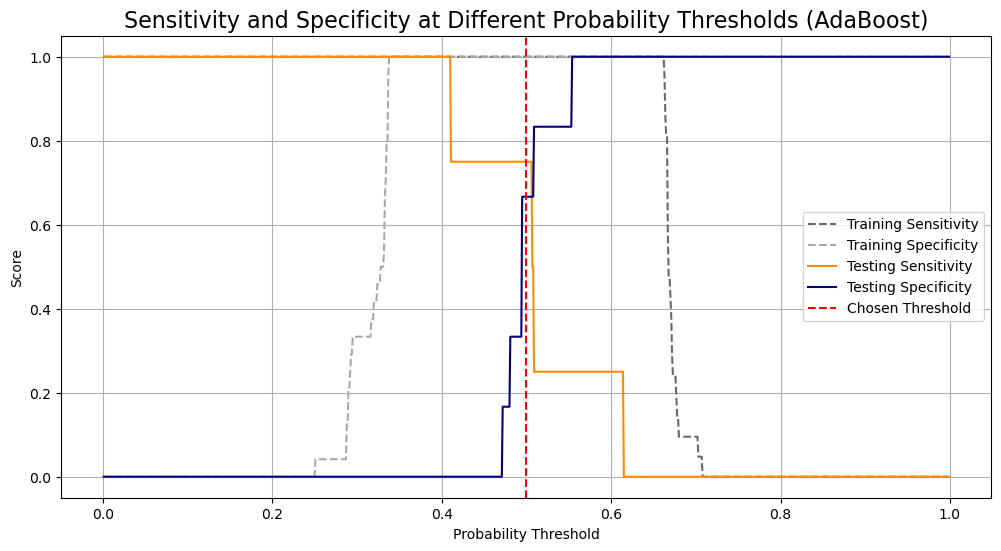

In [232]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Create an AdaBoost model with specific hyperparameters
ada_model = AdaBoostClassifier(n_estimators=160, random_state=42, learning_rate=0.5, )

# Fit the AdaBoost model to the training data
ada_model.fit(imputed_X_train, y_train)

# Make predictions on the validation data
y_prob_val = ada_model.predict_proba(imputed_X_val.values)[:, 1]
y_prob_train = ada_model.predict_proba(imputed_X_train.values)[:, 1]
y_prob_test = ada_model.predict_proba(imputed_X_test.values)[:, 1]

# Choose a specific threshold for classification
chosen_threshold = 0.5


# Make binary predictions based on the chosen threshold for validation data
y_pred_binary_val = (y_prob_val >= chosen_threshold).astype(int)

# Make binary predictions based on the chosen threshold for training data
y_pred_binary_train = (y_prob_train >= chosen_threshold).astype(int)

# Make binary predictions based on the chosen threshold for testing data
y_pred_binary_test = (y_prob_test >= chosen_threshold).astype(int)

# Calculate accuracy for validation, training, and testing data
accuracy_val = accuracy_score(y_val, y_pred_binary_val)
accuracy_train = accuracy_score(y_train, y_pred_binary_train)
accuracy_test = accuracy_score(y_test, y_pred_binary_test)

# Calculate the confusion matrix for validation, training, and testing data
conf_matrix_val = confusion_matrix(y_val, y_pred_binary_val)
conf_matrix_train = confusion_matrix(y_train, y_pred_binary_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_binary_test)

# Calculate sensitivity and specificity from the confusion matrix for validation, training, and testing data
TN_val, FP_val, FN_val, TP_val = conf_matrix_val.ravel()
sensitivity_val = TP_val / (TP_val + FN_val)
specificity_val = TN_val / (TN_val + FP_val)

TN_train, FP_train, FN_train, TP_train = conf_matrix_train.ravel()
sensitivity_train = TP_train / (TP_train + FN_train)
specificity_train = TN_train / (TN_train + FP_train)

TN_test, FP_test, FN_test, TP_test = conf_matrix_test.ravel()
sensitivity_test = TP_test / (TP_test + FN_test)
specificity_test = TN_test / (TN_test + FP_test)

# Print the model metrics at the chosen threshold for validation, training, and testing data

print("\nModel Metrics at Chosen Threshold (Training Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Training Accuracy: {accuracy_train:.3f}")
print(f"Training Sensitivity: {sensitivity_train:.3f}")
print(f"Training Specificity: {specificity_train:.3f}")

print("\nModel Metrics at Chosen Threshold (Testing Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Testing Accuracy: {accuracy_test:.3f}")
print(f"Testing Sensitivity: {sensitivity_test:.3f}")
print(f"Testing Specificity: {specificity_test:.3f}")

# Plot sensitivity and specificity at different probability thresholds for validation data
thresholds = np.arange(0.001, 1.0, 0.001)
sensitivity_values_val = []
specificity_values_val = []


# Plot sensitivity and specificity at different probability thresholds for training data
sensitivity_values_train = []
specificity_values_train = []

for threshold in thresholds:
    y_pred_binary_train = (y_prob_train >= threshold).astype(int)
    TP_train = np.sum((y_train == 1) & (y_pred_binary_train == 1))
    FP_train = np.sum((y_train == 0) & (y_pred_binary_train == 1))
    TN_train = np.sum((y_train == 0) & (y_pred_binary_train == 0))
    FN_train = np.sum((y_train == 1) & (y_pred_binary_train == 0))
    sensitivity_train = TP_train / (TP_train + FN_train)
    specificity_train = TN_train / (TN_train + FP_train)
    sensitivity_values_train.append(sensitivity_train)
    specificity_values_train.append(specificity_train)

# Plot sensitivity and specificity at different probability thresholds for testing data
sensitivity_values_test = []
specificity_values_test = []

for threshold in thresholds:
    y_pred_binary_test = (y_prob_test >= threshold).astype(int)
    TP_test = np.sum((y_test == 1) & (y_pred_binary_test == 1))
    FP_test = np.sum((y_test == 0) & (y_pred_binary_test == 1))
    TN_test = np.sum((y_test == 0) & (y_pred_binary_test == 0))
    FN_test = np.sum((y_test == 1) & (y_pred_binary_test == 0))
    sensitivity_test = TP_test / (TP_test + FN_test)
    specificity_test = TN_test / (TN_test + FP_test)
    sensitivity_values_test.append(sensitivity_test)
    specificity_values_test.append(specificity_test)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, sensitivity_values_train, label='Training Sensitivity', color='dimgrey', linestyle='dashed')
plt.plot(thresholds, specificity_values_train, label='Training Specificity', color='darkgrey', linestyle='dashed')
plt.plot(thresholds, sensitivity_values_test, label='Testing Sensitivity', color='darkorange', )
plt.plot(thresholds, specificity_values_test, label='Testing Specificity', color='navy', )
plt.axvline(x=chosen_threshold, color='red', linestyle='--', label='Chosen Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity at Different Probability Thresholds (AdaBoost)',size=16)
plt.legend()
plt.grid(True)
plt.show()


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(



Model Metrics at Chosen Threshold (Training Data):
Threshold: 0.5
Training Accuracy: 1.000
Training Sensitivity: 1.000
Training Specificity: 1.000

Model Metrics at Chosen Threshold (Testing Data):
Threshold: 0.5
Testing Accuracy: 0.700
Testing Sensitivity: 0.750
Testing Specificity: 0.667

Model Metrics at Chosen Threshold (Validation Data):
Threshold: 0.5
Validation Accuracy: 0.700
Validation Sensitivity: 0.800
Validation Specificity: 0.600


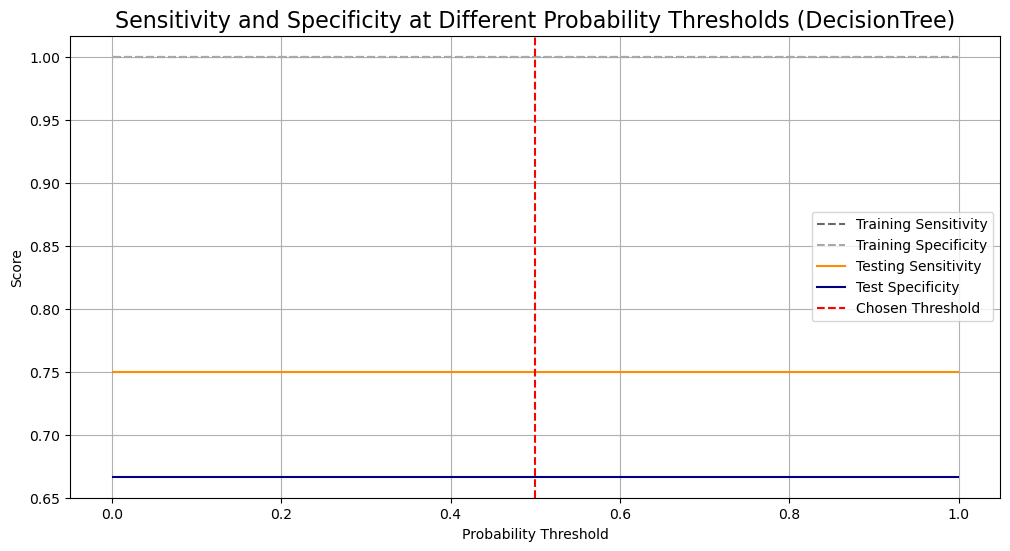

In [234]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Create a Decision Tree model with specific hyperparameters
DT = DecisionTreeClassifier( random_state=42, criterion ='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')

# Fit the Decision Tree model to the training data
DT.fit(imputed_X_train, y_train)

# Make predictions on the validation data
y_prob_val = DT.predict_proba(imputed_X_val.values)[:, 1]
y_prob_train = DT.predict_proba(imputed_X_train.values)[:, 1]
y_prob_test = DT.predict_proba(imputed_X_test.values)[:, 1]

# Choose a specific threshold for classification
chosen_threshold = 0.5

# Make binary predictions based on the chosen threshold for validation data
y_pred_binary_val = (y_prob_val >= chosen_threshold).astype(int)

# Make binary predictions based on the chosen threshold for training data
y_pred_binary_train = (y_prob_train >= chosen_threshold).astype(int)

# Make binary predictions based on the chosen threshold for testing data
y_pred_binary_test = (y_prob_test >= chosen_threshold).astype(int)

# Calculate accuracy for validation, training, and testing data
accuracy_val = accuracy_score(y_val, y_pred_binary_val)
accuracy_train = accuracy_score(y_train, y_pred_binary_train)
accuracy_test = accuracy_score(y_test, y_pred_binary_test)

# Calculate the confusion matrix for validation, training, and testing data
conf_matrix_val = confusion_matrix(y_val, y_pred_binary_val)
conf_matrix_train = confusion_matrix(y_train, y_pred_binary_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_binary_test)

# Calculate sensitivity and specificity from the confusion matrix for validation, training, and testing data
TN_val, FP_val, FN_val, TP_val = conf_matrix_val.ravel()
sensitivity_val = TP_val / (TP_val + FN_val)
specificity_val = TN_val / (TN_val + FP_val)

TN_train, FP_train, FN_train, TP_train = conf_matrix_train.ravel()
sensitivity_train = TP_train / (TP_train + FN_train)
specificity_train = TN_train / (TN_train + FP_train)

TN_test, FP_test, FN_test, TP_test = conf_matrix_test.ravel()
sensitivity_test = TP_test / (TP_test + FN_test)
specificity_test = TN_test / (TN_test + FP_test)

# Print the model metrics at the chosen threshold for validation, training, and testing data
print("\nModel Metrics at Chosen Threshold (Training Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Training Accuracy: {accuracy_train:.3f}")
print(f"Training Sensitivity: {sensitivity_train:.3f}")
print(f"Training Specificity: {specificity_train:.3f}")


print("\nModel Metrics at Chosen Threshold (Testing Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Testing Accuracy: {accuracy_test:.3f}")
print(f"Testing Sensitivity: {sensitivity_test:.3f}")
print(f"Testing Specificity: {specificity_test:.3f}")


print("\nModel Metrics at Chosen Threshold (Validation Data):")
print(f"Threshold: {chosen_threshold}")
print(f"Validation Accuracy: {accuracy_val:.3f}")
print(f"Validation Sensitivity: {sensitivity_val:.3f}")
print(f"Validation Specificity: {specificity_val:.3f}")

# Plot sensitivity and specificity at different probability thresholds for validation data
thresholds = np.arange(0.001, 1.0, 0.001)
sensitivity_values_val = []
specificity_values_val = []

for threshold in thresholds:
    y_pred_binary_val = (y_prob_val >= threshold).astype(int)
    TP_val = np.sum((y_val == 1) & (y_pred_binary_val == 1))
    FP_val = np.sum((y_val == 0) & (y_pred_binary_val == 1))
    TN_val = np.sum((y_val == 0) & (y_pred_binary_val == 0))
    FN_val = np.sum((y_val == 1) & (y_pred_binary_val == 0))
    sensitivity_val = TP_val / (TP_val + FN_val)
    specificity_val = TN_val / (TN_val + FP_val)
    sensitivity_values_val.append(sensitivity_val)
    specificity_values_val.append(specificity_val)

# Plot sensitivity and specificity at different probability thresholds for training data
sensitivity_values_train = []
specificity_values_train = []

for threshold in thresholds:
    y_pred_binary_train = (y_prob_train >= threshold).astype(int)
    TP_train = np.sum((y_train == 1) & (y_pred_binary_train == 1))
    FP_train = np.sum((y_train == 0) & (y_pred_binary_train == 1))
    TN_train = np.sum((y_train == 0) & (y_pred_binary_train == 0))
    FN_train = np.sum((y_train == 1) & (y_pred_binary_train == 0))
    sensitivity_train = TP_train / (TP_train + FN_train)
    specificity_train = TN_train / (TN_train + FP_train)
    sensitivity_values_train.append(sensitivity_train)
    specificity_values_train.append(specificity_train)

# Plot sensitivity and specificity at different probability thresholds for testing data
sensitivity_values_test = []
specificity_values_test = []

for threshold in thresholds:
    y_pred_binary_test = (y_prob_test >= threshold).astype(int)
    TP_test = np.sum((y_test == 1) & (y_pred_binary_test == 1))
    FP_test = np.sum((y_test == 0) & (y_pred_binary_test == 1))
    TN_test = np.sum((y_test == 0) & (y_pred_binary_test == 0))
    FN_test = np.sum((y_test == 1) & (y_pred_binary_test == 0))
    sensitivity_test = TP_test / (TP_test + FN_test)
    specificity_test = TN_test / (TN_test + FP_test)
    sensitivity_values_test.append(sensitivity_test)
    specificity_values_test.append(specificity_test)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, sensitivity_values_train, label='Training Sensitivity', color='dimgrey', linestyle='dashed')
plt.plot(thresholds, specificity_values_train, label='Training Specificity', color='darkgrey', linestyle='dashed')
plt.plot(thresholds, sensitivity_values_test, label='Testing Sensitivity', color='darkorange', )
plt.plot(thresholds, specificity_values_test, label='Test Specificity', color='navy', )
plt.axvline(x=chosen_threshold, color='red', linestyle='--', label='Chosen Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity at Different Probability Thresholds (DecisionTree)',size=16)
plt.legend()
plt.grid(True)
plt.show()


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


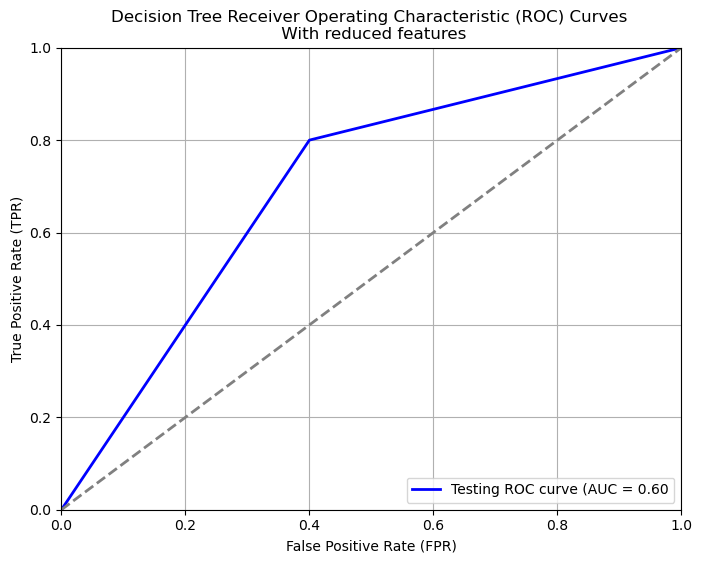

In [148]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# Create a Decision Tree model with specific hyperparameters
DT = DecisionTreeClassifier( random_state=42, criterion ='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')

# Fit the Decision Tree model to the training data
DT.fit(imputed_X_train, y_train)

# Step 1: Make predictions on the validation data using the Decision Tree model
y_pred_proba_val = DT.predict_proba(imputed_X_val.values)[:, 1]

# Step 2: Calculate the ROC curve for the validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)

# Step 3: Calculate the AUC (Area Under the Curve) score for the validation data
auc_score_val = roc_auc_score(y_val, y_pred_proba_val)

# Step 4: Make predictions on the testing data using the Decision Tree model
#y_pred_proba_test = DT.predict_proba(imputed_X_test.values)[:, 1]

# Step 5: Calculate the ROC curve for the testing data
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)

# Step 6: Calculate the AUC (Area Under the Curve) score for the testing data
#auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Step 7: Plot the ROC curves for both validation and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Testing ROC curve (AUC = {auc_score_test:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curves \n With reduced features')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


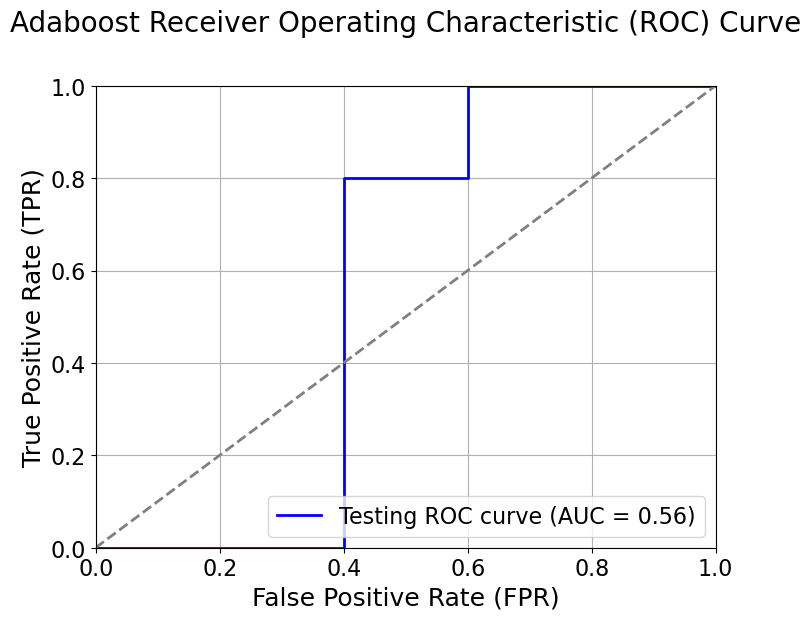

In [133]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Create an AdaBoost model with specific hyperparameters
ada_model = AdaBoostClassifier(n_estimators=160, random_state=42, learning_rate=0.5, )

# Fit the AdaBoost model to the training data
ada_model.fit(imputed_X_train, y_train)

# Step 1: Make predictions on the validation data using the AdaBoostClassifier model
y_pred_proba_val = ada_model.predict_proba(imputed_X_val.values)[:, 1]

# Step 2: Calculate the ROC curve for the validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)

# Step 3: Calculate the AUC (Area Under the Curve) score for the validation data
auc_score_val = roc_auc_score(y_val, y_pred_proba_val)

# Step 4: Make predictions on the testing data using the AdaBoostClassifier model
y_pred_proba_test = ada_model.predict_proba(imputed_X_test.values)[:, 1]

# Step 5: Calculate the ROC curve for the testing data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)

# Step 6: Calculate the AUC (Area Under the Curve) score for the testing data
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Step 7: Plot the ROC curves for both the validation and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Testing ROC curve (AUC = {auc_score_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)', fontsize=18)  # Increase font size for x-axis label
plt.ylabel('True Positive Rate (TPR)', fontsize=18)   # Increase font size for y-axis label
plt.title('Adaboost Receiver Operating Characteristic (ROC) Curve', fontsize=20, y=1.1 )  # Increase font size for title
plt.legend(loc='lower right', fontsize=16)  # Increase font size for legend

plt.xticks(fontsize=16)  # Increase font size for x-axis ticks
plt.yticks(fontsize=16)  # Increase font size for y-axis ticks

plt.grid(True)
plt.show()


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


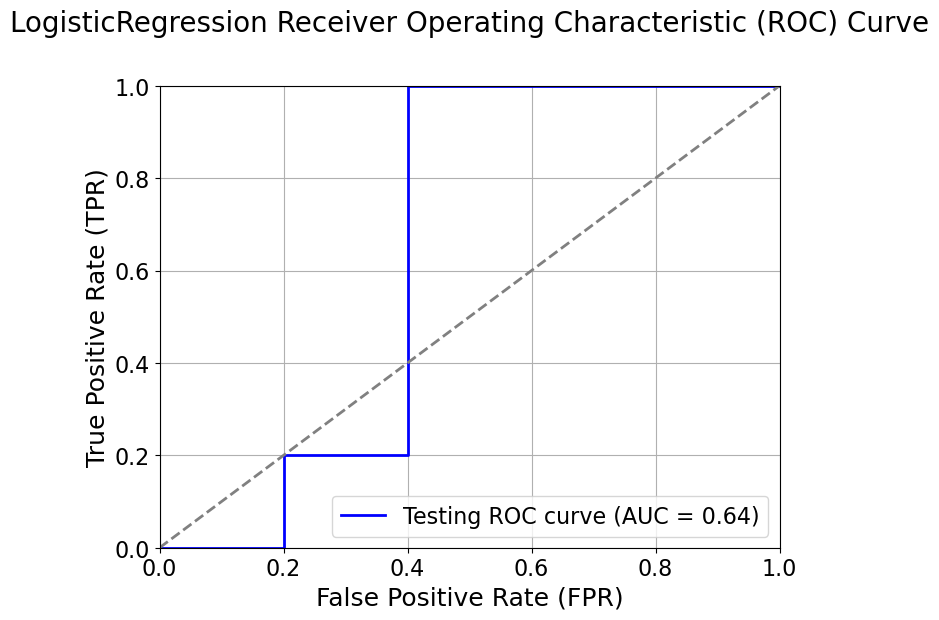

In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Create a Logistic Regression model with specific hyperparameters
LR = LogisticRegression(C=7, penalty='l1', solver='liblinear', max_iter=120)

# Fit the Logistic Regression model to the training data
LR.fit(imputed_X_train, y_train)

# Step 1: Make predictions on the validation data using the LogisticRegression model
y_pred_proba_val = LR.predict_proba(imputed_X_val.values)[:, 1]

# Step 2: Make predictions on the testing data using the LogisticRegression model
y_pred_proba_test = LR.predict_proba(imputed_X_test.values)[:, 1]

# Step 3: Calculate the ROC curve for the validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)
# Calculate the AUC (Area Under the Curve) score for the validation data
auc_score_val = roc_auc_score(y_val, y_pred_proba_val)

'''# Step 4: Calculate the ROC curve for the testing data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
# Calculate the AUC (Area Under the Curve) score for the testing data
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)'''

# Step 5: Plot the ROC curve for both validation and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Testing ROC curve (AUC = {auc_score_val:.2f})')
#plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Testing ROC curve (AUC = {auc_score_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)', fontsize=18)  # Increase font size for x-axis label
plt.ylabel('True Positive Rate (TPR)', fontsize=18)   # Increase font size for y-axis label
plt.title('LogisticRegression Receiver Operating Characteristic (ROC) Curve', fontsize=20, y=1.1 )  # Increase font size for title
plt.legend(loc='lower right', fontsize=16)  # Increase font size for legend

plt.xticks(fontsize=16)  # Increase font size for x-axis ticks
plt.yticks(fontsize=16)  # Increase font size for y-axis ticks

plt.grid(True)
plt.show()


In [50]:
import pandas as pd

# Read the features_counts DataFrame from the CSV file
features_counts = pd.read_csv('/data/home/bt22880/WGBS_TE_pipeline/TensorFlow/Feature_selection/feature_counts_rfecv_boruta_lasso.csv', sep=',')
cgp_list = features_counts['Cpg'].tolist()
#print(cgp_list)

# Keep only the features that are present in the cgp_list
filterd_X_val = imputed_X_val[imputed_X_val.columns.intersection(cgp_list)]
filterd_X_test = imputed_X_test[imputed_X_test.columns.intersection(cgp_list)]
filterd_X_train = imputed_X_train[imputed_X_train.columns.intersection(cgp_list)]


/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


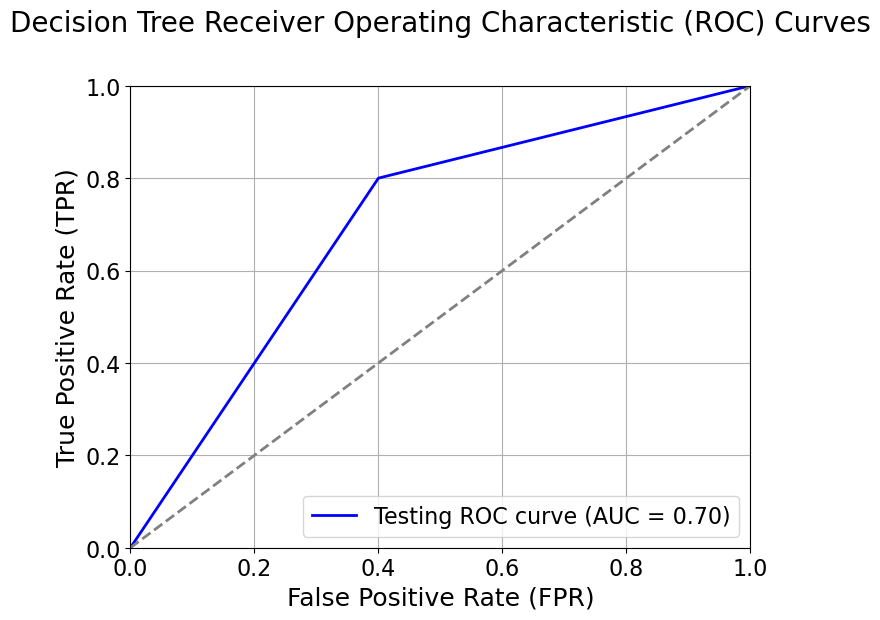

In [149]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# Create a Decision Tree model with specific hyperparameters
DT =  DecisionTreeClassifier( random_state=42, criterion ='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')

# Fit the Decision Tree model to the training data
DT.fit(filterd_X_train, y_train)

# Step 1: Make predictions on the validation data using the Decision Tree model
y_pred_proba_val = DT.predict_proba(filterd_X_val.values)[:, 1]

# Step 2: Calculate the ROC curve for the validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)

# Step 3: Calculate the AUC (Area Under the Curve) score for the validation data
auc_score_val = roc_auc_score(y_val, y_pred_proba_val)

# Step 4: Make predictions on the testing data using the Decision Tree model
#y_pred_proba_test = DT.predict_proba(filterd_X_test.values)[:, 1]

# Step 5: Calculate the ROC curve for the testing data
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)

# Step 6: Calculate the AUC (Area Under the Curve) score for the testing data
#auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Step 7: Plot the ROC curves for both validation and testing data
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Testing ROC curve (AUC = {auc_score_val:.2f})')
#plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Testing ROC curve (AUC = {auc_score_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate (FPR)', fontsize=18)  # Increase font size for x-axis label
plt.ylabel('True Positive Rate (TPR)', fontsize=18)   # Increase font size for y-axis label
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curves', fontsize=20, y=1.1 )  # Increase font size for title
plt.legend(loc='lower right', fontsize=16)  # Increase font size for legend

plt.xticks(fontsize=16)  # Increase font size for x-axis ticks
plt.yticks(fontsize=16)  # Increase font size for y-axis ticks

plt.grid(True)
plt.show()

/data/home/bt22880/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


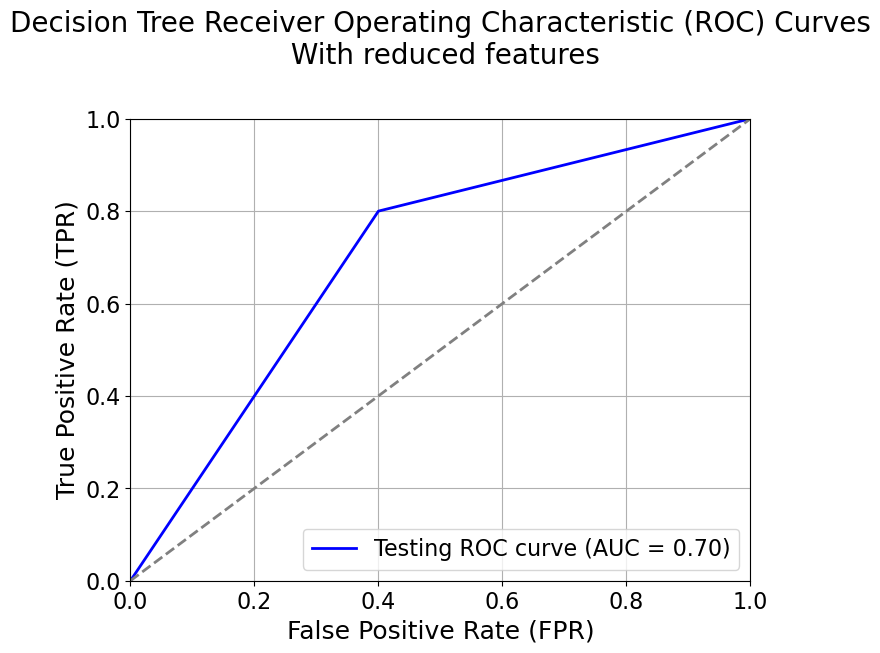

In [150]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import numpy as np

# Assuming you have the filterd_X_train, y_train, filterd_X_val, y_val, filterd_X_test, and y_test

# Create a Decision Tree model with specific hyperparameters
DT =  DecisionTreeClassifier( random_state=42, criterion ='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')

# Fit the Decision Tree model to the training data
DT.fit(filterd_X_train, y_train)

# Step 1: Make predictions on the validation data using the Decision Tree model
y_pred_proba_val = DT.predict_proba(filterd_X_val.values)[:, 1]

# Step 2: Calculate the ROC curve for the validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)

# Step 3: Calculate the AUC (Area Under the Curve) score for the validation data
auc_score_val = roc_auc_score(y_val, y_pred_proba_val)

# Step 4: Make predictions on the testing data using the Decision Tree model
#y_pred_proba_test = DT.predict_proba(filterd_X_test.values)[:, 1]

# Step 5: Calculate the ROC curve for the testing data
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)

# Step 6: Calculate the AUC (Area Under the Curve) score for the testing data
#auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Step 7: Plot the ROC curves for both validation and testing data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Testing ROC curve (AUC = {auc_score_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)', fontsize=18)  # Increase font size for x-axis label
plt.ylabel('True Positive Rate (TPR)', fontsize=18)   # Increase font size for y-axis label
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curves\n With reduced features', fontsize=20, y=1.1 )  # Increase font size for title
plt.legend(loc='lower right', fontsize=16)  # Increase font size for legend

plt.xticks(fontsize=16)  # Increase font size for x-axis ticks
plt.yticks(fontsize=16)  # Increase font size for y-axis ticks

plt.grid(True)
plt.show()




Ensemble Model Metrics:
Accuracy: 0.80
Specificity: 0.60
Sensitivity: 1.00


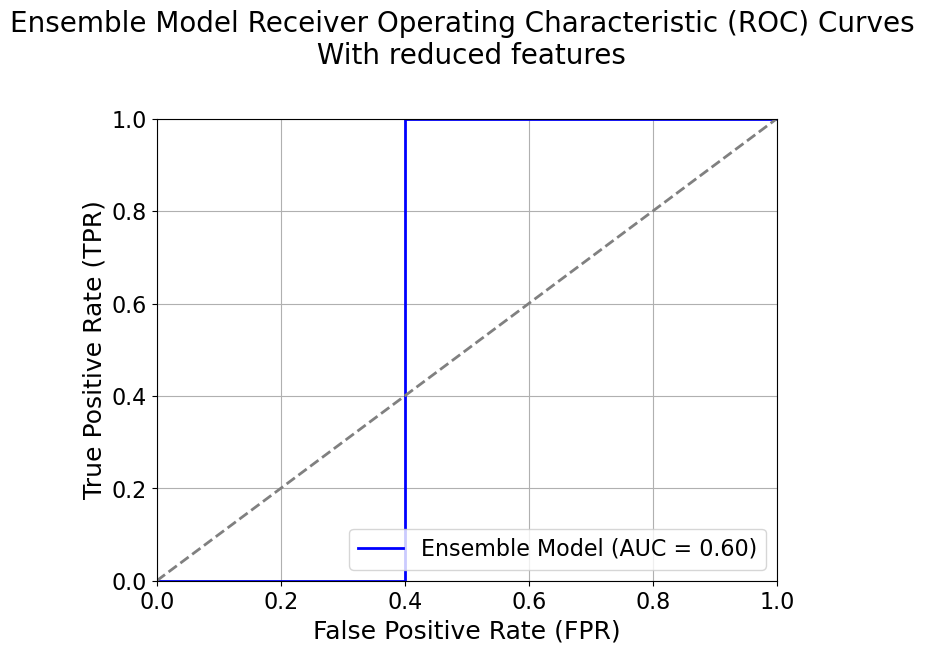

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Define the individual models
ada_model = AdaBoostClassifier(n_estimators=160, random_state=42, learning_rate=0.5)
DT = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')
LR = LogisticRegression(C=7, penalty='l1', solver='liblinear', max_iter=120)

# Create the Voting Classifier by combining the models
ensemble_model = VotingClassifier(estimators=[
    ('ADA', ada_model),
    ('DT', DT),
    ('LR', LR)
], voting='soft', weights=[1.0, 1.5, 0.5])

# Train the ensemble model on the training data
ensemble_model.fit(filterd_X_train, y_train)

# Make predictions on the validation data
y_pred = ensemble_model.predict(filterd_X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Calculate specificity and sensitivity from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

# Calculate the predicted probabilities for the positive class (class 1)
y_probs = ensemble_model.predict_proba(filterd_X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# Calculate the AUC (Area Under the Curve) score
auc = roc_auc_score(y_val, y_probs)

print("Ensemble Model Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Ensemble Model (AUC = {auc:.2f})', color='blue', lw=2,)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)', fontsize=18)  # Increase font size for x-axis label
plt.ylabel('True Positive Rate (TPR)', fontsize=18)   # Increase font size for y-axis label
plt.title('Ensemble Model Receiver Operating Characteristic (ROC) Curves \n With reduced features',  fontsize=20, y=1.1 )
plt.legend(loc='lower right', fontsize=16)  # Increase font size for legend
plt.xticks(fontsize=16)  # Increase font size for x-axis ticks
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

